In [1]:
import diff_gaussian_rasterization as dgr
from diff_gaussian_rasterization import GaussianRasterizationSettings, GaussianRasterizer
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
import bayes3d as b
import jax.numpy as jnp
from random import randint
import pytorch3d.transforms
import jax
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7012/static/


In [116]:
intrinsics = b.Intrinsics(
    height=100,
    width=100,
    fx=100.0, fy=100.0,
    cx=50.0, cy=50.0,
    near=0.01, far=1.75
)
fovX = jnp.arctan(intrinsics.width / 2 / intrinsics.fx) * 2
fovY = jnp.arctan(intrinsics.height / 2 / intrinsics.fy) * 2
tan_fovx = math.tan(fovX)
tan_fovy = math.tan(fovY)

def render_jax(means3D_jax, opacity_jax, scales_jax, rotations_jax, camera_pose_jax, obs_image_jax, intrinsics):
    N = means3D_jax.shape[0]

    means3D = torch.tensor(b.utils.jax_to_torch(means3D_jax), requires_grad=True)
    scales = torch.tensor(b.utils.jax_to_torch(scales_jax), requires_grad=True)
    rotations = torch.tensor(b.utils.jax_to_torch(rotations_jax), requires_grad=True)
    opacity = torch.tensor(b.utils.jax_to_torch(opacity_jax), requires_grad=True)

    means2D = torch.tensor(torch.rand((N, 3)),requires_grad=True,device=device)
    
    proj_matrix = b.utils.jax_to_torch(b.camera.getProjectionMatrix(intrinsics))
    view_matrix = torch.transpose(torch.tensor(np.array(b.inverse_pose(camera_pose_jax))),0,1).cuda()
    raster_settings = GaussianRasterizationSettings(
        image_height=int(intrinsics.height),
        image_width=int(intrinsics.width),
        tanfovx=tan_fovx,
        tanfovy=tan_fovy,
        bg=torch.tensor([intrinsics.far, intrinsics.far, intrinsics.far]).cuda(),
        scale_modifier=1.0,
        viewmatrix=view_matrix,
        projmatrix=view_matrix @ proj_matrix,
        sh_degree=0,
        campos=torch.zeros(3).cuda(),
        prefiltered=False,
        debug=None
    )
    rasterizer = GaussianRasterizer(raster_settings=raster_settings)

    gt_rendered_image, radii = rasterizer(
        means3D = means3D,
        means2D = means2D,
        shs = None,
        colors_precomp = means3D[:,2:3].repeat(1,3),
        opacities = torch.sigmoid(opacity),
        scales = torch.exp(scales),
        rotations = rotations
    )
    obs_image = b.utils.jax_to_torch(obs_image_jax)
    loss = torch.abs(gt_rendered_image - obs_image).mean()
    loss.backward()


    return b.utils.torch_to_jax(gt_rendered_image[2,...]), b.utils.torch_to_jax(means3D.grad), b.utils.torch_to_jax(opacity.grad), loss



In [114]:
b.setup_renderer(intrinsics)
model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models")
mesh_path = os.path.join(model_dir,"obj_" + "{}".format(17).rjust(6, '0') + ".ply")
b.RENDERER.add_mesh_from_file(mesh_path, scaling_factor=1.0/1000.0)

Increasing frame buffer size to (width, height, depth) = (128, 128, 1024)


[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


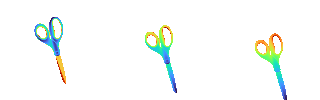

In [115]:
object_pose = b.transform_from_pos(jnp.array([0.0, 0.0, 0.3]))
camera_poses = [jnp.eye(4), b.transform_from_axis_angle(jnp.array([1.0, 0.0, 0.0]), jnp.pi/40), b.transform_from_axis_angle(jnp.array([1.0, 0.0, 0.0]), jnp.pi/20)]

point_cloud_images = [b.RENDERER.render(b.inverse_pose(cp) @ object_pose[None,...], jnp.array([0])) for cp in camera_poses]
gt_images = [torch.tensor(np.array(gt_img[...,2]),device=device).detach() for gt_img in point_cloud_images]
gt_images_stacked = torch.stack(gt_images)
b.hstack_images([b.get_depth_image(img[:,:,2]) for img in point_cloud_images])

/var/tmp/ipykernel_324201/3699069702.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  means3D = torch.tensor(b.utils.jax_to_torch(means3D_jax), requires_grad=True)
/var/tmp/ipykernel_324201/3699069702.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scales = torch.tensor(b.utils.jax_to_torch(scales_jax), requires_grad=True)
/var/tmp/ipykernel_324201/3699069702.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rotations = torch.tensor(b.utils.jax_to_torch(rotations_jax), requires_grad=True)
/var/tmp/ipykernel_324201/3699069702.p

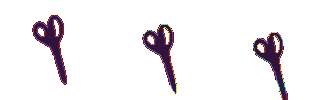

In [126]:
point_cloud_image = point_cloud_images[0][...,:3]
point_cloud = point_cloud_image.reshape(-1,3)
point_cloud_not_far = point_cloud[point_cloud[:,2] < intrinsics.far, :]
means3D = jnp.tile(point_cloud_not_far, (5,1))
N = means3D.shape[0]
opacity, scales, rotations = jnp.ones((N,1)), jnp.ones((N,3))  - 20.0, jnp.ones((N,4)) 

imgs = [render_jax(means3D, opacity, scales, rotations, camera_pose, point_cloud_images[0][...,2],intrinsics)[0] for camera_pose in camera_poses ]
b.clear()
b.show_cloud("gt",b.unproject_depth_jit(point_cloud_images[0][...,2], intrinsics).reshape(-1,3)) 
b.show_cloud("reconstruction",b.unproject_depth_jit(imgs[0], intrinsics).reshape(-1,3),color=b.BLUE) 
b.hstack_images([b.get_depth_image(d) for d in imgs])

In [128]:
camera_pose = camera_poses[0]
gt_img = point_cloud_images[1][...,2]
for _ in range(100):
    img, grad_means, grad_opacity, loss = render_jax(means3D,opacity, scales, rotations, camera_pose, gt_img,intrinsics)
    print(loss)
    means3D = means3D - 0.1 * grad_means
    opacity = opacity - 0.1 * grad_opacity
b.show_cloud("gt",b.unproject_depth_jit(gt_img, intrinsics).reshape(-1,3)) 
b.show_cloud("reconstruction",b.unproject_depth_jit(img, intrinsics).reshape(-1,3),color=b.BLUE) 

/var/tmp/ipykernel_324201/3699069702.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  means3D = torch.tensor(b.utils.jax_to_torch(means3D_jax), requires_grad=True)
/var/tmp/ipykernel_324201/3699069702.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scales = torch.tensor(b.utils.jax_to_torch(scales_jax), requires_grad=True)
/var/tmp/ipykernel_324201/3699069702.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rotations = torch.tensor(b.utils.jax_to_torch(rotations_jax), requires_grad=True)
/var/tmp/ipykernel_324201/3699069702.p

tensor(0.0210, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0211, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0214, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0207, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0210, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0210, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0212, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0207, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0210, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0206, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0209, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0209, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0208, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0208, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0210, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0208, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0205, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0205, device='cuda:0',

In [95]:
grads.shape

(2920, 3)

In [ ]:
l = [
    {'params': [means3D], 'lr': 0.01 ,"name": "xyz"},
    {'params': [opacity], 'lr': 0.05, "name": "opacity"},
    {'params': [scales], 'lr': 0.05, "name": "scaling"},
    {'params': [rotations], 'lr': 0.01, "name": "rotation"}
]
optimizer = torch.optim.SGD(l, lr=0.0)

pbar = tqdm(range(1000))
for _ in pbar:
    imgs = torch.stack([render(means3D, means2D, opacity, scales, rotations, camera_pose) for camera_pose in camera_poses])
    loss = torch.abs(gt_images_stacked - imgs).mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    pbar.set_description(f"{loss.item()}")



In [ ]:
b.clear()
b.show_cloud("gt",b.unproject_depth_jit(gt_images_stacked[0].detach().cpu().numpy(), intrinsics).reshape(-1,3)) 
# b.show_cloud("means", means3D.detach().cpu().numpy(),color=b.RED)
b.show_cloud("reconstruction",b.unproject_depth_jit(convert_to_numpy(imgs[0]), intrinsics).reshape(-1,3),color=b.BLUE) 

b.get_depth_image(convert_to_numpy(imgs[0]))

In [ ]:
img, radii = rasterizer(
    means3D = means3D,
    means2D = means2D,
    shs = None,
    colors_precomp = means3D[:,2:3].repeat(1,3),
    opacities =  torch.tensor(torch.ones((N, 1)),requires_grad=True,device=device),
    scales = torch.exp(scales),
    rotations = rotations
)
depth_image = np.moveaxis(img.detach().cpu().numpy(),0,-1)[...,2]
b.clear()
# b.show_cloud("gt",b.unproject_depth_jit(gt_img, intrinsics).reshape(-1,3)) 
# b.show_cloud("means", means3D.detach().cpu().numpy(),color=b.RED)
b.show_cloud("reconstruction",b.unproject_depth_jit(depth_image, intrinsics).reshape(-1,3),color=b.BLUE) 

b.get_depth_image(depth_image)

In [ ]:
plt.matshow(np.abs(depth_image - gt_img))
plt.colorbar()

In [ ]:
pos = torch.tensor([0.0, 0.0, 0.5],device=device)
quat =  torch.tensor(torch.rand(4,device=device) - 0.5,device=device)

gt_rendered_image =  render(pos, quat).detach()
depth_image = np.moveaxis(gt_rendered_image.detach().cpu().numpy(),0,-1)[...,2]
b.show_cloud("1", b.unproject_depth_jit(depth_image, intrinsics).reshape(-1,3))
viz_gt = b.get_depth_image(depth_image)
viz_gt


In [ ]:
pos = torch.tensor([0.0, 0.0, 0.5],device=device, requires_grad=True)
quat =  torch.tensor(torch.rand(4,device=device) - 0.5,device=device, requires_grad=True)
rendered_image =  render(pos, quat)
depth_image = np.moveaxis(rendered_image.detach().cpu().numpy(),0,-1)[...,2]
b.show_cloud("1", b.unproject_depth_jit(depth_image, intrinsics).reshape(-1,3))
viz = b.get_depth_image(depth_image)
b.hstack_images([viz, viz_gt])

In [ ]:

optimizer = torch.optim.Adam([
    {'params': [pos], 'lr': 0.001, "name": "pos"},
    {'params': [quat], 'lr': 0.001, "name": "quat"},
], lr=0.0, eps=1e-15)

pbar = tqdm(range(1000))
for _ in pbar:
    rendered_image =  render(pos, quat)
    loss = torch.abs(gt_rendered_image - rendered_image).mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    pbar.set_description(f"{loss.item()}")


In [ ]:

depth_image = np.moveaxis(rendered_image.detach().cpu().numpy(),0,-1)[...,2]
b.show_cloud("1", b.unproject_depth_jit(depth_image, intrinsics).reshape(-1,3))
viz = b.get_depth_image(depth_image)
b.hstack_images([viz, viz_gt])
